# Out of fold evaluation for EfficientDet

Hi everyone!

My name is Alex Shonenkov, I am DL/NLP/CV/TS research engineer. Especially I am in Love with NLP & DL.

Recently I have created kernels for this competition:
- [WBF approach for ensemble](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble)
- [[Training] EfficientDet](https://www.kaggle.com/shonenkov/training-efficientdet)
- [[Inference] EfficientDet](https://www.kaggle.com/shonenkov/inference-efficientdet)

# Main Idea

People from ODS slack asked me about competition metrics on my validation split for effdet. So I have decided to publish notebook with calculation oof-score for my models and selection best threshold :) 

For this aims I have trained 5-folds using published [training kernel](https://www.kaggle.com/shonenkov/training-efficientdet). 

It is very simple notebook without any really good idea, but I hope It can help you evaluate effdet models in the future during research!
So, lets start! 

In [1]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

In [1]:
import sys
sys.path.insert(0, "../../../efficientdet-pytorch")
sys.path.insert(0, "../../../omegaconf")
sys.path.insert(0, "../../weightedboxesfusion")
#sys.path.insert(0, '../')

In [2]:
from ensemble_boxes import *
import os
import torch
import numpy as np
import pandas as pd
from glob import glob
from torch.utils.data import Dataset,DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import cv2
import gc
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from effdet import get_efficientdet_config, EfficientDet, DetBenchEval
from effdet.efficientdet import HeadNet
from sklearn.model_selection import StratifiedKFold

#from metrics import calculate_final_score, predict_eval_set, eval_metrics

# Prepare Folds

In [3]:
DATA_DIR = '../../../data/wheat'
marking = pd.read_csv(f'{DATA_DIR}/train.csv')

bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
for i, column in enumerate(['x', 'y', 'w', 'h']):
    marking[column] = bboxs[:,i]
marking.drop(columns=['bbox'], inplace=True)

In [4]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()
df_folds.loc[:, 'bbox_count'] = 1
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/relevance2-nfs/chec/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [5]:
marking.head()

,image_id,width,height,source,x,y,w,h
0,b6ab77fd7,1024,1024,usask_1,834.0,222.0,56.0,36.0
1,b6ab77fd7,1024,1024,usask_1,226.0,548.0,130.0,58.0
2,b6ab77fd7,1024,1024,usask_1,377.0,504.0,74.0,160.0
3,b6ab77fd7,1024,1024,usask_1,834.0,95.0,109.0,107.0
4,b6ab77fd7,1024,1024,usask_1,26.0,144.0,124.0,117.0


In [6]:
len(pd.read_csv(f'{DATA_DIR}/train.csv').image_id.unique())

3373

In [99]:
image_files = os.listdir(os.path.join(DATA_DIR, 'train'))
all_img_ids = [x.split('.')[0] for x in image_files]
no_box_images = set(all_img_ids) - set(marking.image_id.unique())

In [11]:
def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
            ToTensorV2(p=1.0),
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [12]:
TRAIN_ROOT_PATH = f'{DATA_DIR}/train'


def collate_fn(batch):
    return tuple(zip(*batch))


class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]

        image, boxes = self.load_image_and_boxes(index)
        if boxes is None:
            boxes = np.array([[0., 0., 1., 1.]])
            labels = torch.tensor([2.]).long()
        # there is only one class
        else:
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
#                     target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    break

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        if len(records) < 1:
            return image, None
        boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = boxes[:, 1] + boxes[:, 3]
        return image, boxes

In [66]:
df_folds[df_folds['fold'] == 2].index.values.shape

(675,)

In [56]:
np.concatenate([np.array([1,2]), np.array([3,4])], 0)

array([1, 2, 3, 4])

In [67]:
val_ids_all = np.concatenate([df_folds[df_folds['fold'] == 2].index.values, np.array(list(no_box_images))], 0)

In [53]:
val_ids_all.shape

(724,)

In [68]:
    val_set_all = DatasetRetriever(
        image_ids=val_ids_all,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )

    val_loader_all = DataLoader(
        val_set_all,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

In [69]:
    validation_dataset = DatasetRetriever(
        image_ids=df_folds[df_folds['fold'] == 2].index.values,
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )

    validation_loader = DataLoader(
        validation_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

In [70]:
no_box_set = DatasetRetriever(
        image_ids=np.array(list(no_box_images)),
        marking=marking,
        transforms=get_valid_transforms(),
        test=True,
    )

no_box_loader = DataLoader(
        no_box_set,
        batch_size=4,
        shuffle=False,
        num_workers=2,
        drop_last=False,
        collate_fn=collate_fn
    )

# Load Models

In [72]:
def load_net(checkpoint_path):
    config = get_efficientdet_config('tf_efficientdet_d5')
    net = EfficientDet(config, pretrained_backbone=False)

    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))

    checkpoint = torch.load(checkpoint_path)
    net.load_state_dict(checkpoint['model_state_dict'])

    del checkpoint
    gc.collect()

    net = DetBenchEval(net, config)
    net.eval();
    return net.cuda()

#models = [
    #load_net('./ed5-mixup/best-fold-0.pth'),
    #load_net('./ed5-mixup/best-fold-1.pth'),
    #load_net('./ed5-mixup/best-fold-2.pth'),
    #load_net('../input/effdet5-folds-v2/fold3-best.bin'),
    #load_net('../input/effdet5-folds-v2/fold4-best.bin'),
#]
#model = load_net('./ed5-mixup/best-fold-2.pth')
#model = load_net('./effdet5-cutmix-augmix/fold0-best-all-states.bin')
model = load_net('./effdet5-cutmix-augmix/best-fold-2.pth')

In [61]:
!ls effdet5-cutmix-augmix

best-fold-0.pth  best-fold-4.pth	    last-fold-2.pth  log_1.txt
best-fold-1.pth  fold0-best-all-states.bin  last-fold-3.pth  log_2.txt
best-fold-2.pth  last-fold-0.pth	    last-fold-4.pth  log_3.txt
best-fold-3.pth  last-fold-1.pth	    log_0.txt	     log_4.txt


# Out of fold prediction:

In [63]:
eval_metrics(model, val_loader_all)

{'best_score': 0.70707,
 'best_threshold': 0.39,
 0.2: 0.62477,
 0.25: 0.66814,
 0.3: 0.69622,
 0.4: 0.70687,
 0.45: 0.70172,
 0.5: 0.69285,
 0.55: 0.675,
 0.6: 0.64319}

In [64]:
eval_metrics(model, validation_loader)

{'best_score': 0.68876,
 'best_threshold': 0.39,
 0.2: 0.62123,
 0.25: 0.6559,
 0.3: 0.67713,
 0.4: 0.68855,
 0.45: 0.68303,
 0.5: 0.67203,
 0.55: 0.65289,
 0.6: 0.61877}

In [59]:
eval_metrics(model, val_loader_all)

{'best_score': 0.70335,
 'best_threshold': 0.42,
 0.2: 0.62228,
 0.25: 0.66524,
 0.3: 0.69062,
 0.4: 0.70219,
 0.45: 0.70144,
 0.5: 0.69038,
 0.55: 0.6688,
 0.6: 0.63257}

In [12]:
metrics = eval_metrics(model, validation_loader)
metrics

{'best_score': 0.68881,
 'best_threshold': 0.37,
 0.2: 0.62152,
 0.25: 0.65723,
 0.3: 0.67705,
 0.4: 0.68797,
 0.45: 0.68421,
 0.5: 0.67087,
 0.55: 0.64772,
 0.6: 0.60738}

In [98]:
eval_metrics(model, val_loader_all)

{'best_score': 0.70322,
 'best_threshold': 0.41,
 0.3: 0.68891,
 0.37: 0.70282,
 0.4: 0.70277,
 0.42: 0.70293,
 0.45: 0.70014,
 0.5: 0.69349,
 0.55: 0.67508,
 0.6: 0.6431}

In [13]:
for img, target, img_id in validation_loader:
    print(target)
    break

({'boxes': tensor([[ 44.5000, 128.0000, 101.0000, 181.5000],
        [108.0000, 141.0000, 170.5000, 200.5000],
        [ 98.5000,   0.0000, 139.5000,  17.0000],
        [252.0000, 279.0000, 352.0000, 321.0000],
        [209.5000, 180.5000, 278.0000, 229.0000],
        [192.0000, 121.5000, 238.5000, 163.0000],
        [377.0000,  92.0000, 419.0000, 150.0000],
        [164.5000, 205.0000, 214.5000, 247.5000],
        [218.5000,  20.5000, 256.0000,  61.5000],
        [169.0000, 438.5000, 277.0000, 481.0000],
        [129.0000,   0.0000, 175.0000,  38.0000],
        [137.0000,  31.5000, 194.5000,  83.0000],
        [437.5000, 389.0000, 512.0000, 425.5000],
        [354.0000, 293.5000, 399.0000, 333.5000],
        [ 64.0000, 181.5000, 107.5000, 218.5000],
        [405.5000, 480.0000, 486.0000, 512.0000],
        [359.5000,   0.0000, 403.5000,  31.5000],
        [200.5000,  72.5000, 250.5000, 114.5000],
        [264.5000,  44.5000, 309.5000,  82.0000],
        [ 38.0000, 375.0000, 115.0000, 

# Show predictions

In [89]:
def make_predictions(model, images, score_threshold=0.1):
    images = torch.stack(images).cuda().float()
    predictions = []
    with torch.no_grad():
        det = model(images, torch.tensor([1]*images.shape[0]).float().cuda())
        for i in range(images.shape[0]):
            boxes = det[i].detach().cpu().numpy()[:,:4]    
            scores = det[i].detach().cpu().numpy()[:,4]
            indexes = np.where(scores > score_threshold)[0]
            boxes = boxes[indexes]
            boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
            predictions.append({
                'boxes': boxes[indexes],
                'scores': scores[indexes],
            })
    return [predictions]

def run_wbf(predictions, image_index, image_size=512, iou_thr=0.55, skip_box_thr=0.2, weights=None):
    boxes = [(prediction[image_index]['boxes']/(image_size-1)).tolist()  for prediction in predictions]
    scores = [prediction[image_index]['scores'].tolist()  for prediction in predictions]
    labels = [np.ones(prediction[image_index]['scores'].shape[0]).tolist() for prediction in predictions]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size-1)
    return boxes, scores, labels

In [90]:
def predict_test_set_for_pseudo(model, no_box_loader):
    results = []

    for images, t, image_ids in no_box_loader:
        predictions = make_predictions(model, images)
        #print('predictions len:', len(predictions))
        for i, image in enumerate(images):
            boxes, scores, labels = run_wbf(predictions, image_index=i)
            boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
            image_id = image_ids[i]

            boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
            boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

            #result = {
            #    'image_id': image_id,
            #    'PredictionString': format_prediction_string(boxes, scores),
            #    'boxes': boxes
            #}
            print(boxes)
            for b in boxes.astype(np.float32):
                results.append({
                    'image_id': 'chicm'+image_id,
                    'height': 1024,
                    'width': 1024,
                    'source': 'pseudo',
                    'x': b[0],
                    'y': b[1],
                    'w': b[2],
                    'h': b[3]
                })
    return results

In [91]:
results = predict_test_set_for_pseudo(model, no_box_loader)

[]
[[948 843  64  61]]
[]
[]
[]
[]
[[118 995  95  28]]
[]
[[860 972  92  51]
 [207 972  70  51]
 [ 74 237  56  60]]
[[914 176 109  96]]
[]
[]
[]
[]
[]
[]
[[458 478  49  99]]
[]
[]
[]
[[158 918  73  64]
 [  0 428  51 106]]
[]
[[941 777  82  78]
 [ 19   0 118  70]]
[]
[]
[[248 350 109  72]]
[]
[]
[]
[]
[[  0 370 150 118]
 [492 438 202 118]]
[[  0 880  46 103]]
[]
[]
[]
[]
[]
[]
[]
[]
[[398  69  89  68]
 [268   6  59  65]
 [302  85  63  66]
 [952 952  70  60]
 [ 67 125  74  84]
 [ 40 132  75  79]
 [196 174 105  99]]
[]
[[906 461 113  92]]
[]
[[359 928  72  56]]
[]
[]
[]
[]


In [92]:
pd.DataFrame(results)

,image_id,height,width,source,x,y,w,h
0,chicm83a94fc79,1024,1024,pseudo,948.0,843.0,64.0,61.0
1,chicm3116768f0,1024,1024,pseudo,118.0,995.0,95.0,28.0
2,chicmed00a614d,1024,1024,pseudo,860.0,972.0,92.0,51.0
3,chicmed00a614d,1024,1024,pseudo,207.0,972.0,70.0,51.0
4,chicmed00a614d,1024,1024,pseudo,74.0,237.0,56.0,60.0
5,chicm5901a73fe,1024,1024,pseudo,914.0,176.0,109.0,96.0
6,chicmab20ec355,1024,1024,pseudo,458.0,478.0,49.0,99.0
7,chicm1a9792bfc,1024,1024,pseudo,158.0,918.0,73.0,64.0
8,chicm1a9792bfc,1024,1024,pseudo,0.0,428.0,51.0,106.0
9,chicm0cf7ef43d,1024,1024,pseudo,941.0,777.0,82.0,78.0


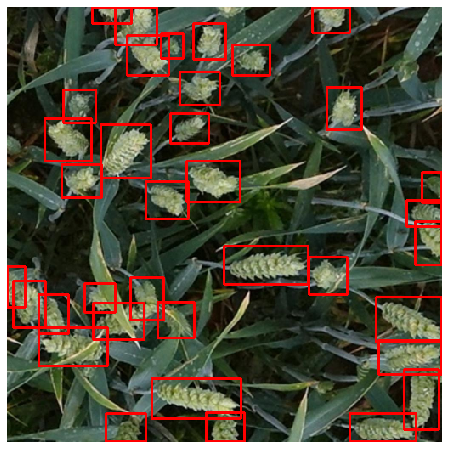

In [32]:
import matplotlib.pyplot as plt

for j, (images, targets, image_ids) in enumerate(validation_loader):
    break

predictions = make_predictions(model, images)

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.5)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

In [24]:
import matplotlib.pyplot as plt

for j, (images, targets, image_ids) in enumerate(no_box_loader):
    #break
    #print(targets)
    print('targets:', targets)

    predictions = make_predictions(model, images)
    #print(len(predictions[0]))
    #print([x['scores'] for x in predictions[0]])

i = 0
sample = images[i].permute(1,2,0).cpu().numpy()

boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.5)
boxes = boxes.astype(np.int32).clip(min=0, max=511)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample, (box[0], box[1]), (box[2], box[3]), (1, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample);

targets: ({'boxes': tensor([[0.0000, 0.0000, 0.5000, 0.5000]]), 'labels': tensor([2]), 'image_id': tensor([0])}, {'boxes': tensor([[0.0000, 0.0000, 0.5000, 0.5000]]), 'labels': tensor([2]), 'image_id': tensor([1])}, {'boxes': tensor([[0.0000, 0.0000, 0.5000, 0.5000]]), 'labels': tensor([2]), 'image_id': tensor([2])}, {'boxes': tensor([[0.0000, 0.0000, 0.5000, 0.5000]]), 'labels': tensor([2]), 'image_id': tensor([3])})


NameError: name 'make_predictions' is not defined

In [67]:
def format_prediction_string(boxes, scores):
    pred_strings = []
    for j in zip(scores, boxes):
        pred_strings.append("{0:.4f} {1} {2} {3} {4}".format(j[0], j[1][0], j[1][1], j[1][2], j[1][3]))
    return " ".join(pred_strings)

In [73]:
results = []

for images, targets, image_ids in no_box_loader:
    predictions = make_predictions(model, images)
    for i, image in enumerate(images):
        boxes, scores, labels = run_wbf(predictions, image_index=i, skip_box_thr=0.37)
        boxes = (boxes*2).astype(np.int32).clip(min=0, max=1023)
        image_id = image_ids[i]
        
        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]

        result = {
            'image_id': image_id,
            'PredictionString': format_prediction_string(boxes, scores)
        }
        results.append(result)

In [74]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
#test_df.to_csv('submission.csv', index=False)
test_df

,image_id,PredictionString
0,155c440e8,
1,b45c5294d,
2,2d80f9c49,
3,952e7d15c,
4,45fddc611,
5,69352f3fa,
6,7e1caf1f7,
7,8de789df8,0.4050 0 210 59 64
8,de2a3cf37,
9,526d737d1,


In [77]:
def show_img(img_id):
    fn = f'{DATA_DIR}/train/{img_id}.jpg'
    img = cv2.imread(fn)
    plt.imshow(img)

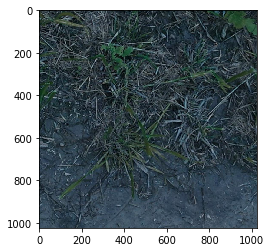

In [80]:
show_img('9e21e7969')

In [46]:
eval_metrics(model, no_box_loader)

{'best_score': 1.0,
 'best_threshold': 0.66,
 0.2: 0.63265,
 0.25: 0.77551,
 0.3: 0.87755,
 0.4: 0.89796,
 0.45: 0.93878,
 0.5: 0.95918,
 0.55: 0.95918,
 0.6: 0.97959}

In [26]:
preds = predict_eval_set(model, no_box_loader)

In [27]:
preds

[{'pred_boxes': array([[   0,  992,   15, 1023],
         [   3, 1008,   64, 1023],
         [   0,  951,   18, 1020],
         [ 555, 1011,  640, 1023],
         [   0,  969,   48, 1023],
         [   0,  844,   42,  926],
         [   0,  844,   22,  929],
         [1010,  998, 1023, 1021],
         [ 340,  561,  438,  660],
         [1013,  752, 1023,  862],
         [   0,  805,   15,  911],
         [1011,  788, 1023,  889],
         [  25, 1012,  116, 1023],
         [1009,  821, 1023,  922],
         [ 695,  481,  872,  536],
         [1015,  703, 1023,  814],
         [1014,  950, 1023, 1019],
         [ 973,  844, 1023,  930],
         [ 779, 1012,  864, 1023],
         [ 552,  980,  637, 1022],
         [ 578, 1014,  677, 1023],
         [ 522, 1014,  616, 1023],
         [  94, 1010,  173, 1023],
         [1003,    0, 1023,   11],
         [1015,  656, 1023,  768],
         [   0,  902,    9, 1005],
         [   0,  872,   12,  962],
         [   2,  983,   89, 1023],
      

In [45]:
calculate_final_score(preds, 0.5)

0.9591836734693877

In [97]:
import pandas as pd
import numpy as np
import numba
import re
from glob import glob
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple
from tqdm.notebook import tqdm

import pandas as pd
import numpy as np
import numba
import re
import cv2
import ast
import matplotlib.pyplot as plt

from numba import jit
from typing import List, Union, Tuple


@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area


@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

def show_result(sample_id, preds, gt_boxes):
    sample = cv2.imread(f'{TRAIN_ROOT_PATH}/{sample_id}.jpg', cv2.IMREAD_COLOR)
    sample = cv2.cvtColor(sample, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for pred_box in preds:
        cv2.rectangle(
            sample,
            (pred_box[0], pred_box[1]),
            (pred_box[2], pred_box[3]),
            (220, 0, 0), 2
        )

    for gt_box in gt_boxes:    
        cv2.rectangle(
            sample,
            (gt_box[0], gt_box[1]),
            (gt_box[2], gt_box[3]),
            (0, 0, 220), 2
        )

    ax.set_axis_off()
    ax.imshow(sample)
    ax.set_title("RED: Predicted | BLUE - Ground-truth")
    
# Numba typed list!
iou_thresholds = numba.typed.List()

for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

def calculate_final_score(all_predictions, score_threshold):
    final_scores = []
    for i in range(len(all_predictions)):
        gt_boxes = all_predictions[i]['gt_boxes'].copy()
        pred_boxes = all_predictions[i]['pred_boxes'].copy()
        scores = all_predictions[i]['scores'].copy()
        image_id = all_predictions[i]['image_id']
        labels = all_predictions[i]['labels']

        indexes = np.where(scores>score_threshold)
        #print(indexes)
        #print(labels)
        pred_boxes = pred_boxes[indexes]
        scores = scores[indexes]
        #print(len(scores))
        
        if labels[0] == 2: # no ground truth boxes
            if len(scores) == 0:
                image_precision = 1.
            else:
                image_precision = 0.
        else:
            image_precision = calculate_image_precision(gt_boxes, pred_boxes,thresholds=iou_thresholds,form='pascal_voc')
        
        final_scores.append(image_precision)

    return np.mean(final_scores)

#############################################################
import torch

def predict_eval_set(model, validation_loader, imsize=512):
    all_predictions = []

    for images, targets, image_ids in tqdm(validation_loader, total=len(validation_loader)):
        with torch.no_grad():
            images = torch.stack(images)
            images = images.cuda().float()
            det = model(images, torch.tensor([1]*images.shape[0]).float().cuda())

            for i in range(images.shape[0]):
                boxes = det[i].detach().cpu().numpy()[:,:4]    
                scores = det[i].detach().cpu().numpy()[:,4]
                boxes[:, 2] = boxes[:, 2] + boxes[:, 0]
                boxes[:, 3] = boxes[:, 3] + boxes[:, 1]
                
                labels = targets[i]['labels'].cpu().numpy()
                gt_boxes = (targets[i]['boxes'].cpu().numpy()*(1024//imsize)).clip(min=0, max=1023).astype(int)
                if hasattr(validation_loader.dataset, 'yxyx') and validation_loader.dataset.yxyx is True:
                    gt_boxes[:, [0,1,2,3]] = gt_boxes[:, [1,0,3,2]]
                
                all_predictions.append({
                    'pred_boxes': (boxes*(1024//imsize)).clip(min=0, max=1023).astype(int),
                    'scores': scores,
                    'gt_boxes': gt_boxes,
                    'image_id': image_ids[i],
                    'labels': labels
                })
    return all_predictions

def eval_metrics(model, validation_loader, imsize=512):
    all_predictions = predict_eval_set(model, validation_loader, imsize)
    
    metrics = {}
    score_thresholds = [0.3, 0.35, 0.37, 0.4, 0.42, 0.45, 0.47, 0.5, 0.55, 0.6]
    best_final_score, best_score_threshold = 0, 0
    for score_threshold in tqdm(np.arange(0, 1, 0.01), total=np.arange(0, 1, 0.01).shape[0]):
        final_score = calculate_final_score(all_predictions, score_threshold)
        if score_threshold in score_thresholds: 
            metrics[score_threshold] = round(final_score, 5)
        if final_score > best_final_score:
            best_final_score = final_score
            best_score_threshold = score_threshold

        metrics['best_score'] = round(best_final_score, 5)
        metrics['best_threshold'] = round(best_score_threshold, 5)
    return metrics